In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Lbar for M31 - GADGET

In [4]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path = '/home/ornela/SimCLUES/'
# path = '/home/omarioni/'
aa = np.loadtxt(path + 'redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,300,-1) #SNAPSHOTS

# path = '/mnt/is2/alejandro/ornella/'

for isnap in snapshot:
    
    path = '/home/ornela/SimCLUES/'
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3.*aexp[isnap])
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)
#     A2_2, phi, rbin2 = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)
    
#     print isnap
    
#     if A2max > 0.2:        
#         plt.plot(rbin,A2)
#         plt.plot(rbin2,A2_2)
#         plt.axhline(y=0.15,ls='--', color='r')
#         plt.axhline(y=A2max,ls='--', color='g')
#         plt.axvline(x=rmax,ls='--', color='g')
#         plt.show()
#     else:
#         print 'no existe'
# med = mean(phi[1:5])

# #---lbar2---------------------------------------------------------------------------------
#     phii = phi - phimax
      
    
#     for i in range(0,len(phii)-2):
#         if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
#             if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
#                 pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
#                 ordenada = phii[i]- pend*rbin[i]
#                 lbar1 = (np.arcsin(0.3) - ordenada)/pend
#                 break
#         elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
#             if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
#                 pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
#                 ordenada = phii[i]- pend*rbin[i]
#                 lbar1 = (-np.arcsin(0.3) - ordenada)/pend
#                 break

#---lbar 1 ----------------------------------------------------------------------
    finterp = sint.interp1d(rbin,A2)
    point = np.linspace(rmax,3*aexp[isnap],100000)
    
    hbar  = 0.15
    resta = finterp(point) - hbar

    
    mask, = np.where(resta < 0.)
    
    lbar = point[mask][0]
    
#     mask, = np.where(rbin >= rmax )
#     point = A2[mask]
#     radio = rbin[mask]
#     hbar  = 0.15
#     resta = point - hbar

#     for kk,_ in enumerate(point):
#         if resta[kk] < 0:
#             break

#     pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
#     y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

#     lbar = (hbar - y0)/ pend

    
# # --------------------------------------------------------------------------------------------------------------------
    path = '/home/ornela/PYTHON/'
#     path = '/home/omarioni/'
    
    archivo1 =  open(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
                   str('%12.6f'% lbar) +'\n')
    archivo1.close()

#lbarvstime2.dat usa la interpolacion de interp1d

### Lbar for M31 - GASOLINE

In [6]:
import h5py
import rotation_mio as rot
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

path = '/home/ornela/SimCLUES/'
# path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,32,-1):
    path = '/home/ornela/SimCLUES/'
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    cm   = snap['subhalo_001/Center'].value
    r200 = snap['subhalo_001/R200'].value
    time = snap['subhalo_001/Time'].value
    h    = snap['subhalo_001/h'].value
    aexp = snap['subhalo_001/aexp'].value
    
    pstr = snap['subhalo_001/Str/Coordinates'].value
    mstr = snap['subhalo_001/Str/Masses'].value
    vel  = snap['subhalo_001/Str/Velocities'].value

#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
#----------------------------------------------------------------------
    
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

#---lbar2---------------------------------------------------------------------------------
#     phii = phi - phimax

#     for i in range(0,len(phii)-2):
#         if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
#             if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
#                 pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
#                 ordenada = phii[i]- pend*rbin[i]
#                 lbar1 = (np.arcsin(0.3) - ordenada)/pend
#                 break
#         elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
#             if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
#                 pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
#                 ordenada = phii[i]- pend*rbin[i]
#                 lbar1 = (-np.arcsin(0.3) - ordenada)/pend
#                 break
#     print snapshot[j], j
#---lbar 1 ----------------------------------------------------------------------
#     if A2max > 0.2:
#         print 'todo ok'
#     else: 
#         print 'no existis'
        
    finterp = sint.interp1d(rbin,A2)
    point = np.linspace(rmax,3*aexp,100000)

    hbar  = 0.15
    resta = finterp(point) - hbar


    mask, = np.where(resta < 0.)

    lbar = point[mask][0]

# #----------------------------------------------------------------------
#     mask, = np.where(rbin >= rmax )
#     point = A2[mask]
#     radio = rbin[mask]
#     hbar  = 0.15
#     resta = point - hbar

#     for kk,_ in enumerate(point):
#         if resta[kk] < 0:
#             break

#     pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
#     y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

#     lbar2 = (hbar - y0)/ pend
    
#--------------------------------------------------------------------------------------------------------------------
    path2= '/home/ornela/PYTHON/'
#     path2 = '/home/omarioni/'
    archivo1 =  open(path2+'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime2.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
                   str('%12.6f'% lbar) +'\n')
    archivo1.close()

### Lbar for MW - GASOLINE

In [7]:
import h5py
import rotation_mio as rot
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------
path = '/home/ornela/SimCLUES/'
# path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,44,-1):
    path = '/home/ornela/SimCLUES/'
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    cm   = snap['subhalo_002/Center'].value
    r200 = snap['subhalo_002/R200'].value
    time = snap['subhalo_002/Time'].value
    h    = snap['subhalo_002/h'].value
    aexp = snap['subhalo_002/aexp'].value
    
    pstr = snap['subhalo_002/Str/Coordinates'].value
    mstr = snap['subhalo_002/Str/Masses'].value
    vel  = snap['subhalo_002/Str/Velocities'].value

#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
#----------------------------------------------------------------------
    
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

#---lbar2---------------------------------------------------------------------------------
#     phii = phi - phimax

#     for i in range(0,len(phii)-2):
#         if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
#             if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
#                 pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
#                 ordenada = phii[i]- pend*rbin[i]
#                 lbar1 = (np.arcsin(0.3) - ordenada)/pend
#                 break
#         elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
#             if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
#                 pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
#                 ordenada = phii[i]- pend*rbin[i]
#                 lbar1 = (-np.arcsin(0.3) - ordenada)/pend
#                 break

#     print snapshot[j], j
#---lbar 1 ----------------------------------------------------------------------
#     if A2max > 0.2:
#         print 'todo ok'
#     else: 
#         print 'no existis'
#     
#     plt.plot(rbin,A2)
#     plt.axhline(y=0.15,ls='--', color='r')
#     plt.axhline(y=A2max,ls='--', color='g')
#     plt.axvline(x=rmax,ls='--', color='g')
#     plt.show()
    
    
    finterp = sint.interp1d(rbin,A2)
    point = np.linspace(rmax,3*aexp,100000)

    hbar  = 0.15
    resta = finterp(point) - hbar


    mask, = np.where(resta < 0.)

    lbar = point[mask][0]
    
#     print la

# #----------------------------------------------------------------------
#     mask, = np.where(rbin >= rmax )
#     point = A2[mask]
#     radio = rbin[mask]
#     hbar  = 0.15
#     resta = point - hbar

#     for kk,_ in enumerate(point):
#         if resta[kk] < 0:
#             break

#     pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
#     y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

#     lbar2 = (hbar - y0)/ pend
    
#--------------------------------------------------------------------------------------------------------------------
    path2= '/home/ornela/PYTHON/'
#     path2 = '/home/omarioni/'
    archivo1 =  open(path2+'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime2.dat','a')
    archivo1.write(str('%12.6f'% time) +'\t'+
                   str('%12.6f'% lbar) +'\n')
    archivo1.close()

In [8]:
path = '/home/ornela/PYTHON/'
# path = '/home/omarioni/'

# M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime.dat')
# time_M31gd = M31_gd[:,0]
# lbar_M31gd = M31_gd[:,1]

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
time_M31gd = M31_gd[:,0]
lbar_M31gd = M31_gd[:,1]

#------------------------------------------------------------------------------------------

# MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_lbarvstime.dat')
# time_MWgd  = MW_gd[:,0]
# # lbar1_MWgd = MW_gd[:,1]
# lbar2_MWgd = MW_gd[:,2]

#------------------------------------------------------------------------------------------

M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime2.dat')
time_M31gs = M31_gs[:,0]
lbar_M31gs = M31_gs[:,1]

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime2.dat')
time_MWgs = MW_gs[:,0]
lbar_MWgs = MW_gs[:,1]



In [12]:
# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barra_G1/lbar_time.dat')
# time0 = cm[:,1]
# lbar0 = cm[:,2]

# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barraG1_salida/lbar_time2.dat')
# time1 = cm[:,1]
# lbar1 = cm[:,2]

# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barra_G2/lbar_time.dat')
# time0_ = cm[:,1]
# lbar0_ = cm[:,2]

# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs_/barraG2_salida/lbar_time.dat')
# time1_ = cm[:,1]
# lbar1_ = cm[:,2]

In [3]:
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/'
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/'

cm0   = np.loadtxt(path + 'rcorot_phi_time.dat')
time0 = cm0[:,1]
rcor  = cm0[:,2]

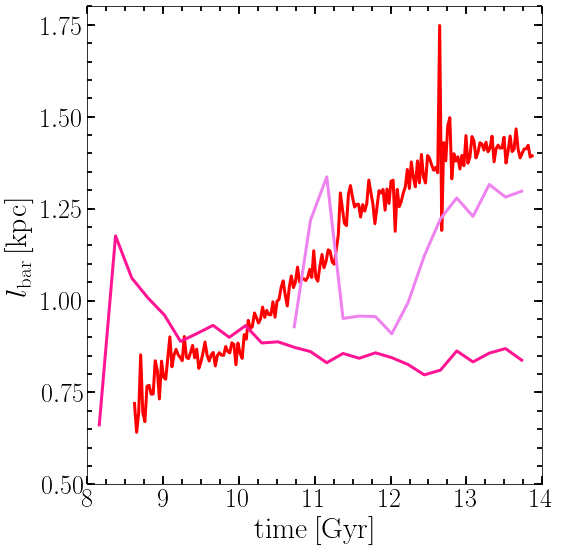

In [14]:
from __future__ import unicode_literals
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95, wspace=0., hspace= 0)

ax.plot(time_M31gd ,lbar_M31gd,'-', lw=3,  color='red')
ax.plot(time_M31gs ,lbar_M31gs,'-', lw=3, color='deeppink')
ax.plot(time_MWgs ,lbar_MWgs,'-', lw=3, color='violet')
ax.set_xlabel('$\mathrm{time\:[Gyr]}$', fontsize=30)
ax.set_ylabel('$l_{\mathrm{bar}}\:[\mathrm{kpc}]$', fontsize=30)
ax.set_xticks([8,9,10,11,12,13,14])
ax.set_yticks([0.5,0.75,1,1.25,1.5,1.75])
ax.set_ylim(0.5,1.8)
ax.set_xlim(8,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax.xaxis.set_minor_locator(MultipleLocator(1/4.)) 
ax.yaxis.set_minor_locator(MultipleLocator(1/20.)) 

# ax[0,0].fill_between([7,15],0,0.14, facecolor='k', alpha=0.2, color='k') #, hatch='\\'


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/lbar_time.pdf', dpi = 100, xxbox_inches='tight')
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/lbar_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

In [56]:
print 

8.623489


1024


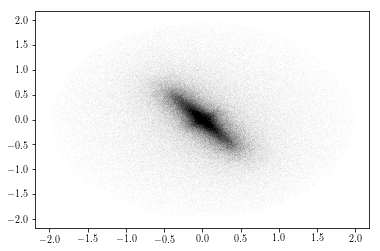

1008


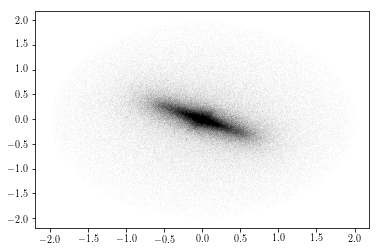

0992


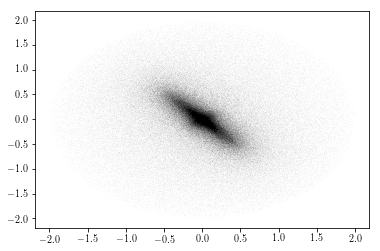

0976


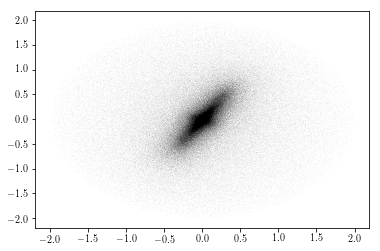

0960


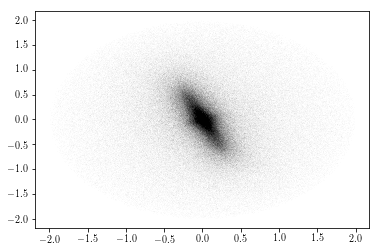

0944


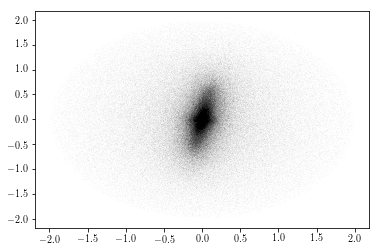

0928


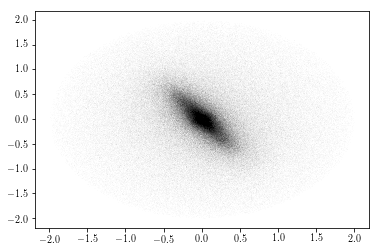

0912


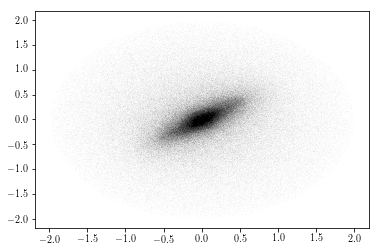

0896


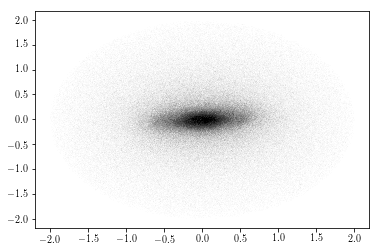

0880


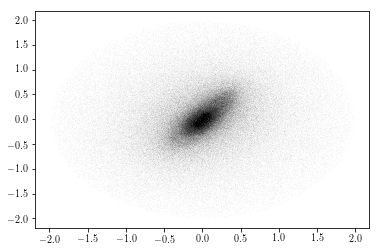

0864


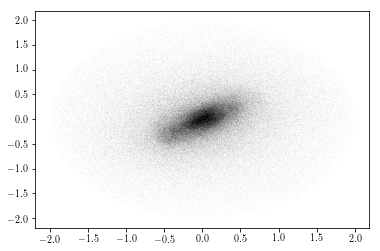

0848


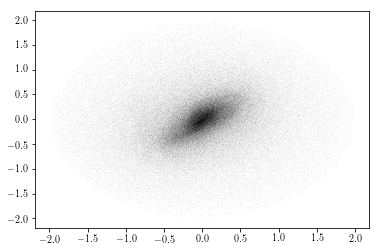

0832


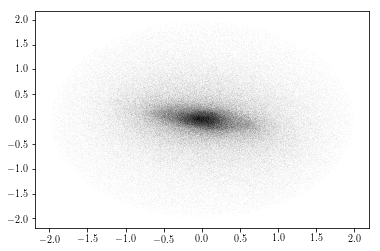

0816


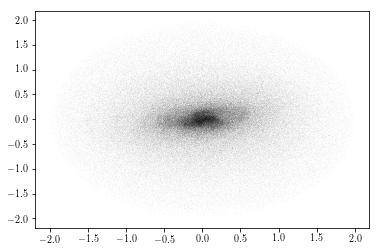

0800


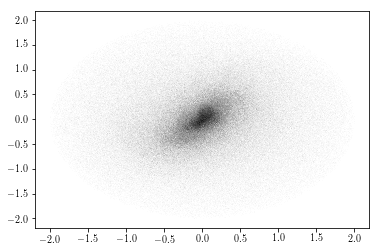

0784


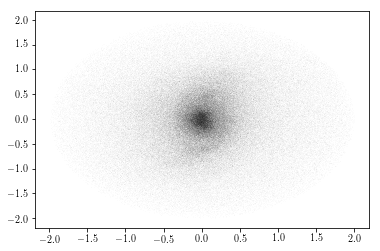

0768


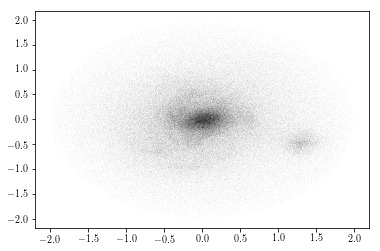

0752


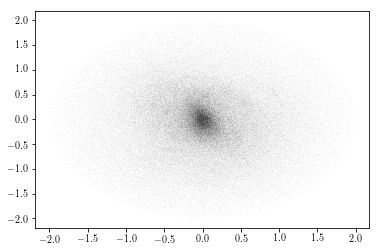

0736


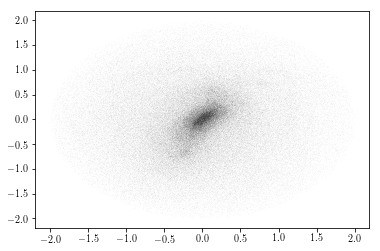

0720


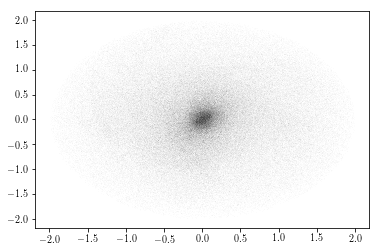

0704


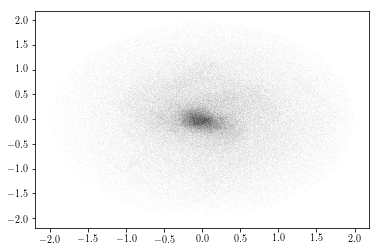

0688


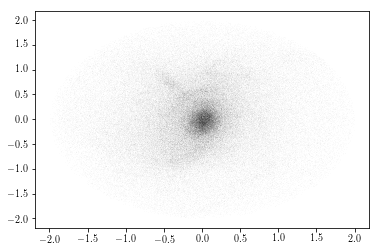

0672


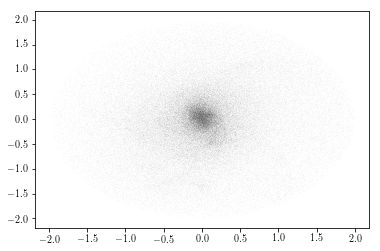

0656


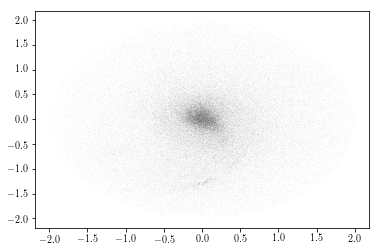

0640


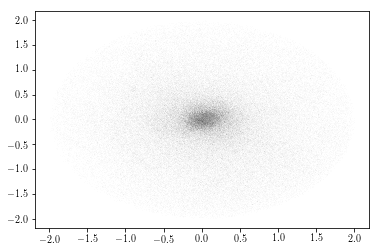

0624


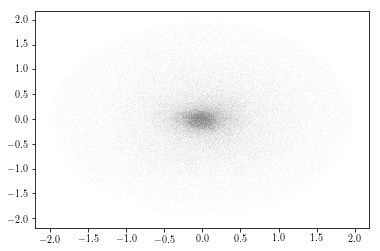

0608


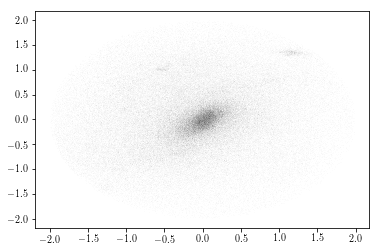

0592


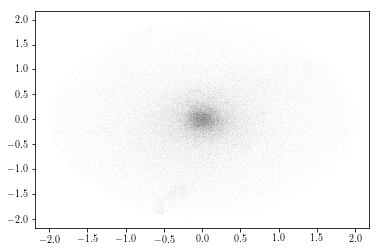

0576


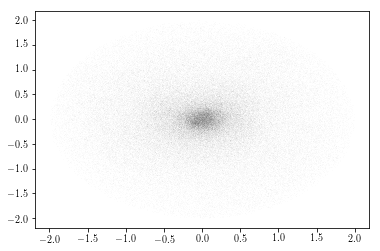

0560


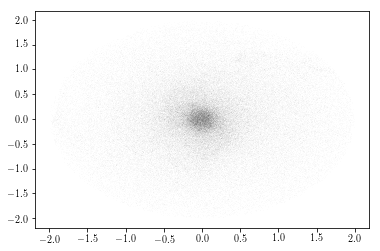

0544


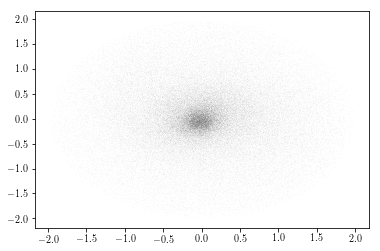

0528


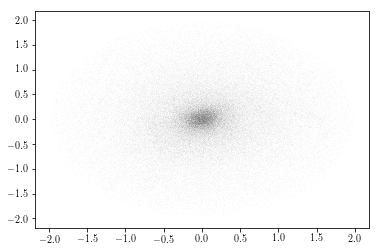

0512


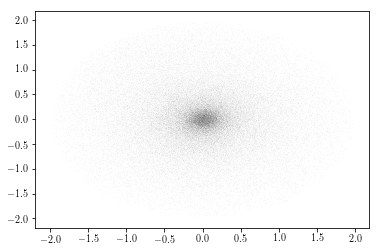

0496


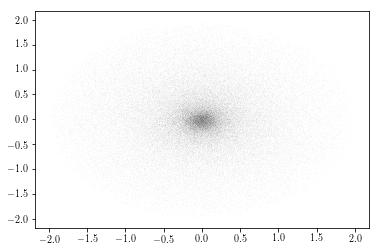

0480


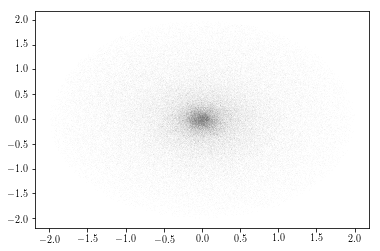

0464


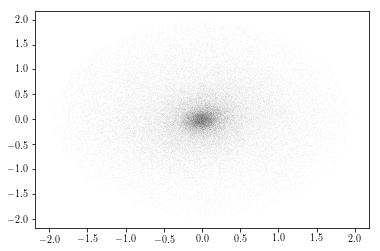

0453


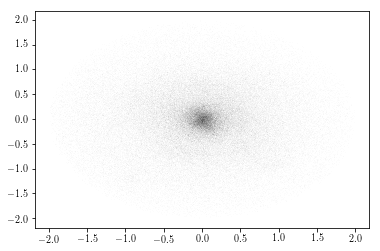

0448


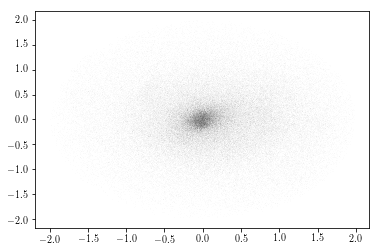

0432


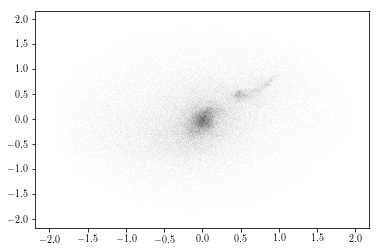

In [4]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import barstrength2 as strng
import time_conversion as tiempo
import sphviewer as sph
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

a0 = 1.
vector = (1,2,4)
vector2 = ('M31', 'MW')
vector3 = ('A','B')
carpeta = ('9in1_M31/', '9in1_MW/')

#path = 'home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(59,20,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    print snapshot[j]

    for i in range(1,2):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pdrk = snap['subhalo_00' + str('%s' %vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_00' + str('%s' %vector[i]) + '/Drk/Masses'].value

        z = a0/aexp - 1.
        #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xdrk = pdrk[:,0]-cm[0]
        ydrk = pdrk[:,1]-cm[1]
        zdrk = pdrk[:,2]-cm[2]
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0] 
        v_y = vel[:,1] 
        v_z = vel[:,2] 

        #----------------------masas----------------------------

        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

        #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]             

        #--------------------------------------------         
        veloc,=np.where(r<r50)

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        ##posiciones de partículas que se quiere graficar
        ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        plt.plot(xn[np.where(r<2.)],yn[np.where(r<2.)],'k.', markersize=0.01)
        plt.show()